#Here we examine the object identification results from some real world data
#

In [1]:
#load in the netcdf files provided
#netcdf_file = "KCYS_2017-06-12T20:29:10Z.nc.gz" #Isolated Cell Data
netcdf_file = "KOAX_2014-06-03T21:36:49Z.nc.gz" #Multi-celluar Data

import gzip
import shutil
import xarray as xr
import numpy as np

# Step 1: Decompress
if netcdf_file.lower().endswith('.gz'):
    with gzip.open(netcdf_file, "rb") as f_in:
        with open("data.nc", "wb") as f_out:
            shutil.copyfileobj(f_in, f_out)
            netcdf_file = "data.nc"
        
ds_xy = xr.open_dataset(netcdf_file)

#step 2: remove file....."data.nc"

In [2]:
#ds_xy.info()

In [3]:
#we have create a dataset with 3 different inputs to be used with 
#our object identifiers, 
#    VIL (Vertically Integrated Liquid), 
#    Composite_Reflectivity (max Ref in vertical column), 
#    Lowest Reflectivity 
#
#We have conviently converted the azimuth/range data to xy coordinates on a 1 km grid
#using inverse distance weighted (thanks wradlib!). This was accomplised with the hotspot
#repository located at:
#    https://github.com/NOAA-National-Severe-Storms-Laboratory/hotspots
#
# <more info here about the cases>


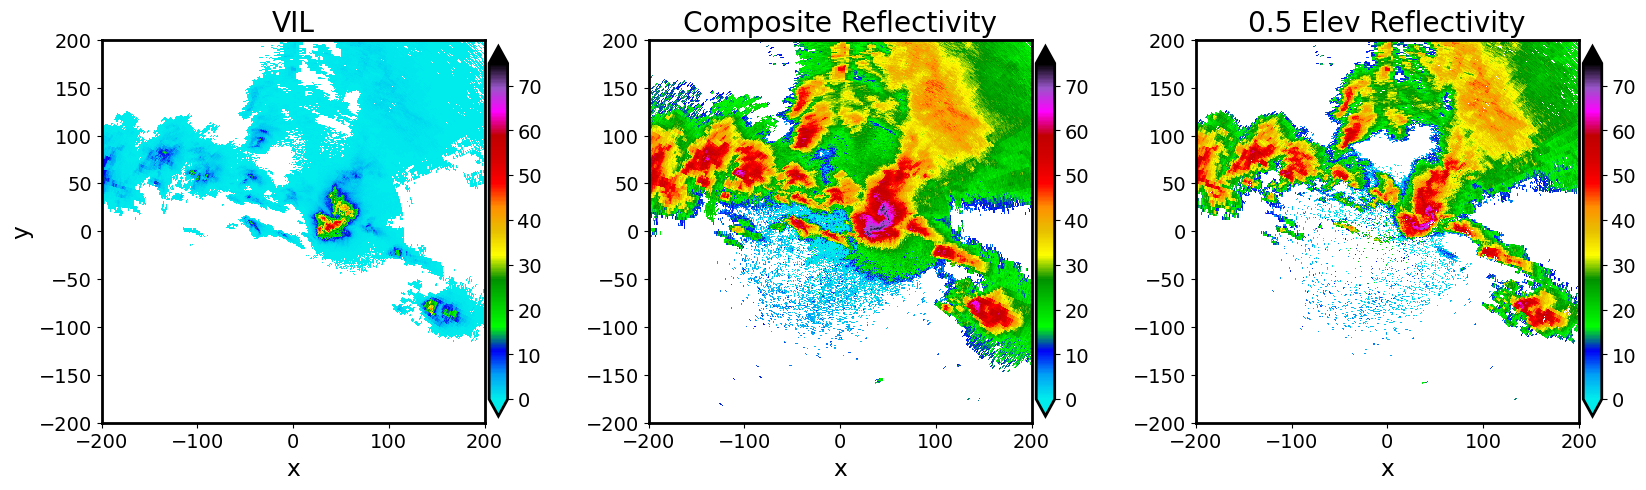

In [4]:
#viewable plots
import matplotlib.pyplot as plt

plt.rcParams.update(plt.rcParamsDefault)

plt.rcParams.update(
        {'font.size': 14.0,
         'axes.titlesize': 'x-large',
         'axes.linewidth': 2.0,
         'axes.labelsize': 'large'}
    )

#select different views
#xlim = (-100, 100)
#ylim = (-100, 100)

xlim = (-200, 200)
ylim = (-200, 200)

#xlim = (-60, 40)
#ylim = (-100, 0)

fig = plt.figure(figsize=(20, 6))
ax1 = fig.add_subplot(131)
ax1.set_aspect('equal')

ds_xy["VIL"].where(ds_xy["VIL"]>-10).plot(ax=ax1, x='x', y='y', vmin=0.0, vmax=75.0,
                        xlim=xlim, ylim=ylim, cmap='NWSRef',
                        add_colorbar=True,
                        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'',
                                     'shrink':0.8})

ax1.set_title("VIL")

ax2 = fig.add_subplot(132)
ax2.set_aspect('equal')


ds_xy["Comp_Ref"].where(ds_xy["Comp_Ref"]>-10).plot(ax=ax2, x='x', y='y', vmin=0.0, vmax=75.0,
                        xlim=xlim, ylim=ylim, cmap='NWSRef',
                        add_colorbar=True,
                        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'',
                                     'shrink':0.8})

ax2.set_title("Composite Reflectivity")
ax2.set_ylabel("")

ax3 = fig.add_subplot(133)
ax3.set_aspect('equal')


ds_xy["Lowest_Ref"].where(ds_xy["Lowest_Ref"]>-10).plot(ax=ax3, x='x', y='y', vmin=0.0, vmax=75.0,
                        xlim=xlim, ylim=ylim, cmap='NWSRef',
                        add_colorbar=True,
                        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'',
                                     'shrink':0.8})

ax3.set_title("0.5 Elev Reflectivity")
ax3.set_ylabel("")

plt.show()


In [5]:
#We've selected parameters (without optimization) for each object identification routine
#Set the dimensions:
y = np.arange(xlim[0], xlim[1])
x = np.arange(ylim[0], ylim[1])
xx,yy = np.meshgrid(x,y)



In [6]:
#parameter sets for the Enhanced Watershed Technique
EW_refl_params = {'min_thresh':25,
            'max_thresh':80,
            'data_increment':20,
            'area_threshold': 100,
            'dist_btw_objects': 25} 
#EW_refl_params = {param_set}

EW_vil_params= {'min_thresh':5,
            'max_thresh':80,
            'data_increment':5,
            'area_threshold': 100,
            'dist_btw_objects': 25} 
#EW_vil_params = {param_set}

In [7]:
#run the object identification:
import sys

sys.path.append("/home/john.krause/python/frdd-monte-python")
import monte_python

data = ds_xy["VIL"].values

#print(type(data))
#print(data.shape)
input_data = np.where(data > 1, data, 0)
#data_tuple = (dim_tuple, input_data)
storm_labels, object_props = monte_python.label(  input_data = input_data, 
                       method ='watershed', 
                       return_object_properties=True, 
                       params = EW_vil_params 
                       )
ds_xy["EW_vil_objects"] = (("y", "x"), storm_labels.data)

In [8]:
#Parameter Sets for the Iterative Watershed technique
param_set = [ {'min_thresh':35,
                                 'max_thresh':80,
                                 'data_increment':5,
                                 'area_threshold': 100,
                                 'dist_btw_objects': 50} , 
            
              {'min_thresh':45,
                                 'max_thresh':80,
                                 'data_increment':5,
                                 'area_threshold': 50,
                                 'dist_btw_objects': 10} 
            ]

IW_refl_params = {'params': param_set }

param_set = [ {'min_thresh':5,
                                 'max_thresh':60,
                                 'data_increment':2,
                                 'area_threshold': 100,
                                 'dist_btw_objects': 50} , 
            
              {'min_thresh':30,
                                 'max_thresh':60,
                                 'data_increment':2,
                                 'area_threshold': 50,
                                 'dist_btw_objects': 10} 
            ]

IW_vil_params = {'params': param_set }

In [9]:
data = ds_xy["VIL"].values
#print (data)
input_data = np.where(data > 2, data, 0)
storm_labels, object_props = monte_python.label(  input_data = input_data, 
                       method ='iterative_watershed', 
                       return_object_properties=True, 
                       params = IW_vil_params 
                       )
ds_xy["IW_vil_objects"] = (("y", "x"), storm_labels.data)

In [10]:
#Parameter sets for MCIT
MCIT_refl_params = {'params': {'valley_depth': 5.0, 'min_value': 30.0 } }
MCIT_vil_params = {'params': {'valley_depth': 2.0, 'min_value': 1.0 } }


In [11]:
data = ds_xy["VIL"].values
#print (data)
input_data = np.where(data > 2, data, 0)
storm_labels, object_props = monte_python.label(  input_data = input_data, 
                       method ='mcit', 
                       return_object_properties=True, 
                       params = MCIT_vil_params 
                       )
ds_xy["MCIT_vil_objects"] = (("y", "x"), storm_labels.data)

mcit params: 


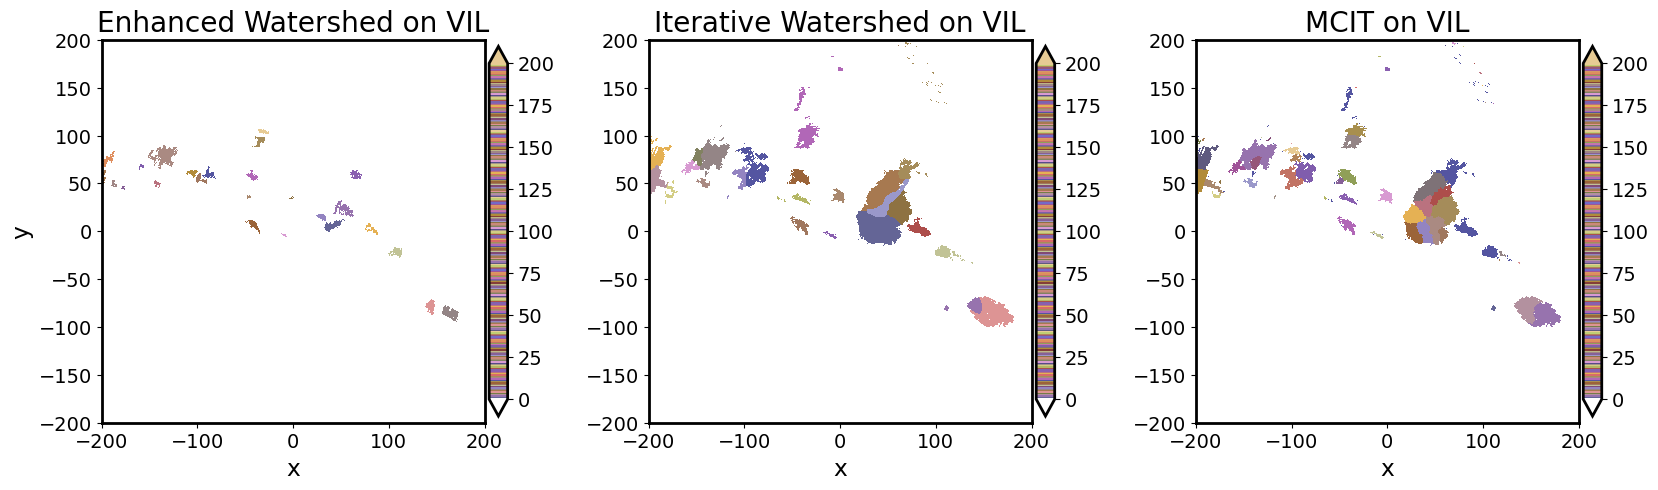

In [12]:
from monte_python.util import get_obj_cmap

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

plt.rcParams.update(
        {'font.size': 14.0,
         'axes.titlesize': 'x-large',
         'axes.linewidth': 2.0,
         'axes.labelsize': 'large'}
    )

#plot out the three methods
fig = plt.figure(figsize=(20, 6))
ax1 = fig.add_subplot(131)

cmap = get_obj_cmap()

ax1.set_aspect('equal')

ds_xy["EW_vil_objects"].where(ds_xy["EW_vil_objects"]>-10).plot(ax=ax1, x='x', y='y', vmin=0.0, vmax=200.0,
                        xlim=xlim, ylim=ylim, cmap=cmap,
                        add_colorbar=True,
                        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'',
                                     'shrink':0.8})

ax1.set_title("Enhanced Watershed on VIL")

ax2 = fig.add_subplot(132)
ax2.set_aspect('equal')


ds_xy["IW_vil_objects"].where(ds_xy["IW_vil_objects"]>-10).plot(ax=ax2, x='x', y='y', vmin=0.0, vmax=200.0,
                        xlim=xlim, ylim=ylim, cmap=cmap,
                        add_colorbar=True,
                        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'',
                                     'shrink':0.8})

ax2.set_title("Iterative Watershed on VIL")
ax2.set_ylabel("")

ax3 = fig.add_subplot(133)
ax3.set_aspect('equal')


ds_xy["MCIT_vil_objects"].where(ds_xy["MCIT_vil_objects"]>-10).plot(ax=ax3, x='x', y='y', vmin=0.0, vmax=200.0,
                        xlim=xlim, ylim=ylim, cmap=cmap,
                        add_colorbar=True,
                        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'',
                                     'shrink':0.8})

ax3.set_title("MCIT on VIL")
ax3.set_ylabel("")

plt.show()

In [13]:
#compute the objet identifiers on the composite refl and lowest refl
data = ds_xy["Comp_Ref"].values

#print(type(data))
#print(data.shape)
input_data = np.where(data > 1, data, 0)
#data_tuple = (dim_tuple, input_data)
storm_labels, object_props = monte_python.label(  input_data = input_data, 
                       method ='watershed', 
                       return_object_properties=True, 
                       params = EW_refl_params 
                       )
ds_xy["EW_cr_objects"] = (("y", "x"), storm_labels.data)

In [14]:
data = ds_xy["Comp_Ref"].values

input_data = np.where(data > 2, data, 0)
storm_labels, object_props = monte_python.label(  input_data = input_data, 
                       method ='iterative_watershed', 
                       return_object_properties=True, 
                       params = IW_refl_params 
                       )
ds_xy["IW_cr_objects"] = (("y", "x"), storm_labels.data)

In [15]:
data = ds_xy["Comp_Ref"].values
input_data = np.where(data > 2, data, 0)
storm_labels, object_props = monte_python.label(  input_data = input_data, 
                       method ='mcit', 
                       return_object_properties=True, 
                       params = MCIT_refl_params 
                       )
ds_xy["MCIT_cr_objects"] = (("y", "x"), storm_labels.data)

mcit params: 


In [16]:
data = ds_xy["Lowest_Ref"].values

#print(type(data))
#print(data.shape)
input_data = np.where(data > 1, data, 0)
#data_tuple = (dim_tuple, input_data)
storm_labels, object_props = monte_python.label(  input_data = input_data, 
                       method ='watershed', 
                       return_object_properties=True, 
                       params = EW_refl_params 
                       )
ds_xy["EW_lr_objects"] = (("y", "x"), storm_labels.data)

In [17]:
data = ds_xy["Lowest_Ref"].values

input_data = np.where(data > 2, data, 0)
storm_labels, object_props = monte_python.label(  input_data = input_data, 
                       method ='iterative_watershed', 
                       return_object_properties=True, 
                       params = IW_refl_params 
                       )
ds_xy["IW_lr_objects"] = (("y", "x"), storm_labels.data)

In [18]:
data = ds_xy["Lowest_Ref"].values
input_data = np.where(data > 2, data, 0)
storm_labels, object_props = monte_python.label(  input_data = input_data, 
                       method ='mcit', 
                       return_object_properties=True, 
                       params = MCIT_refl_params 
                       )
ds_xy["MCIT_lr_objects"] = (("y", "x"), storm_labels.data)

mcit params: 


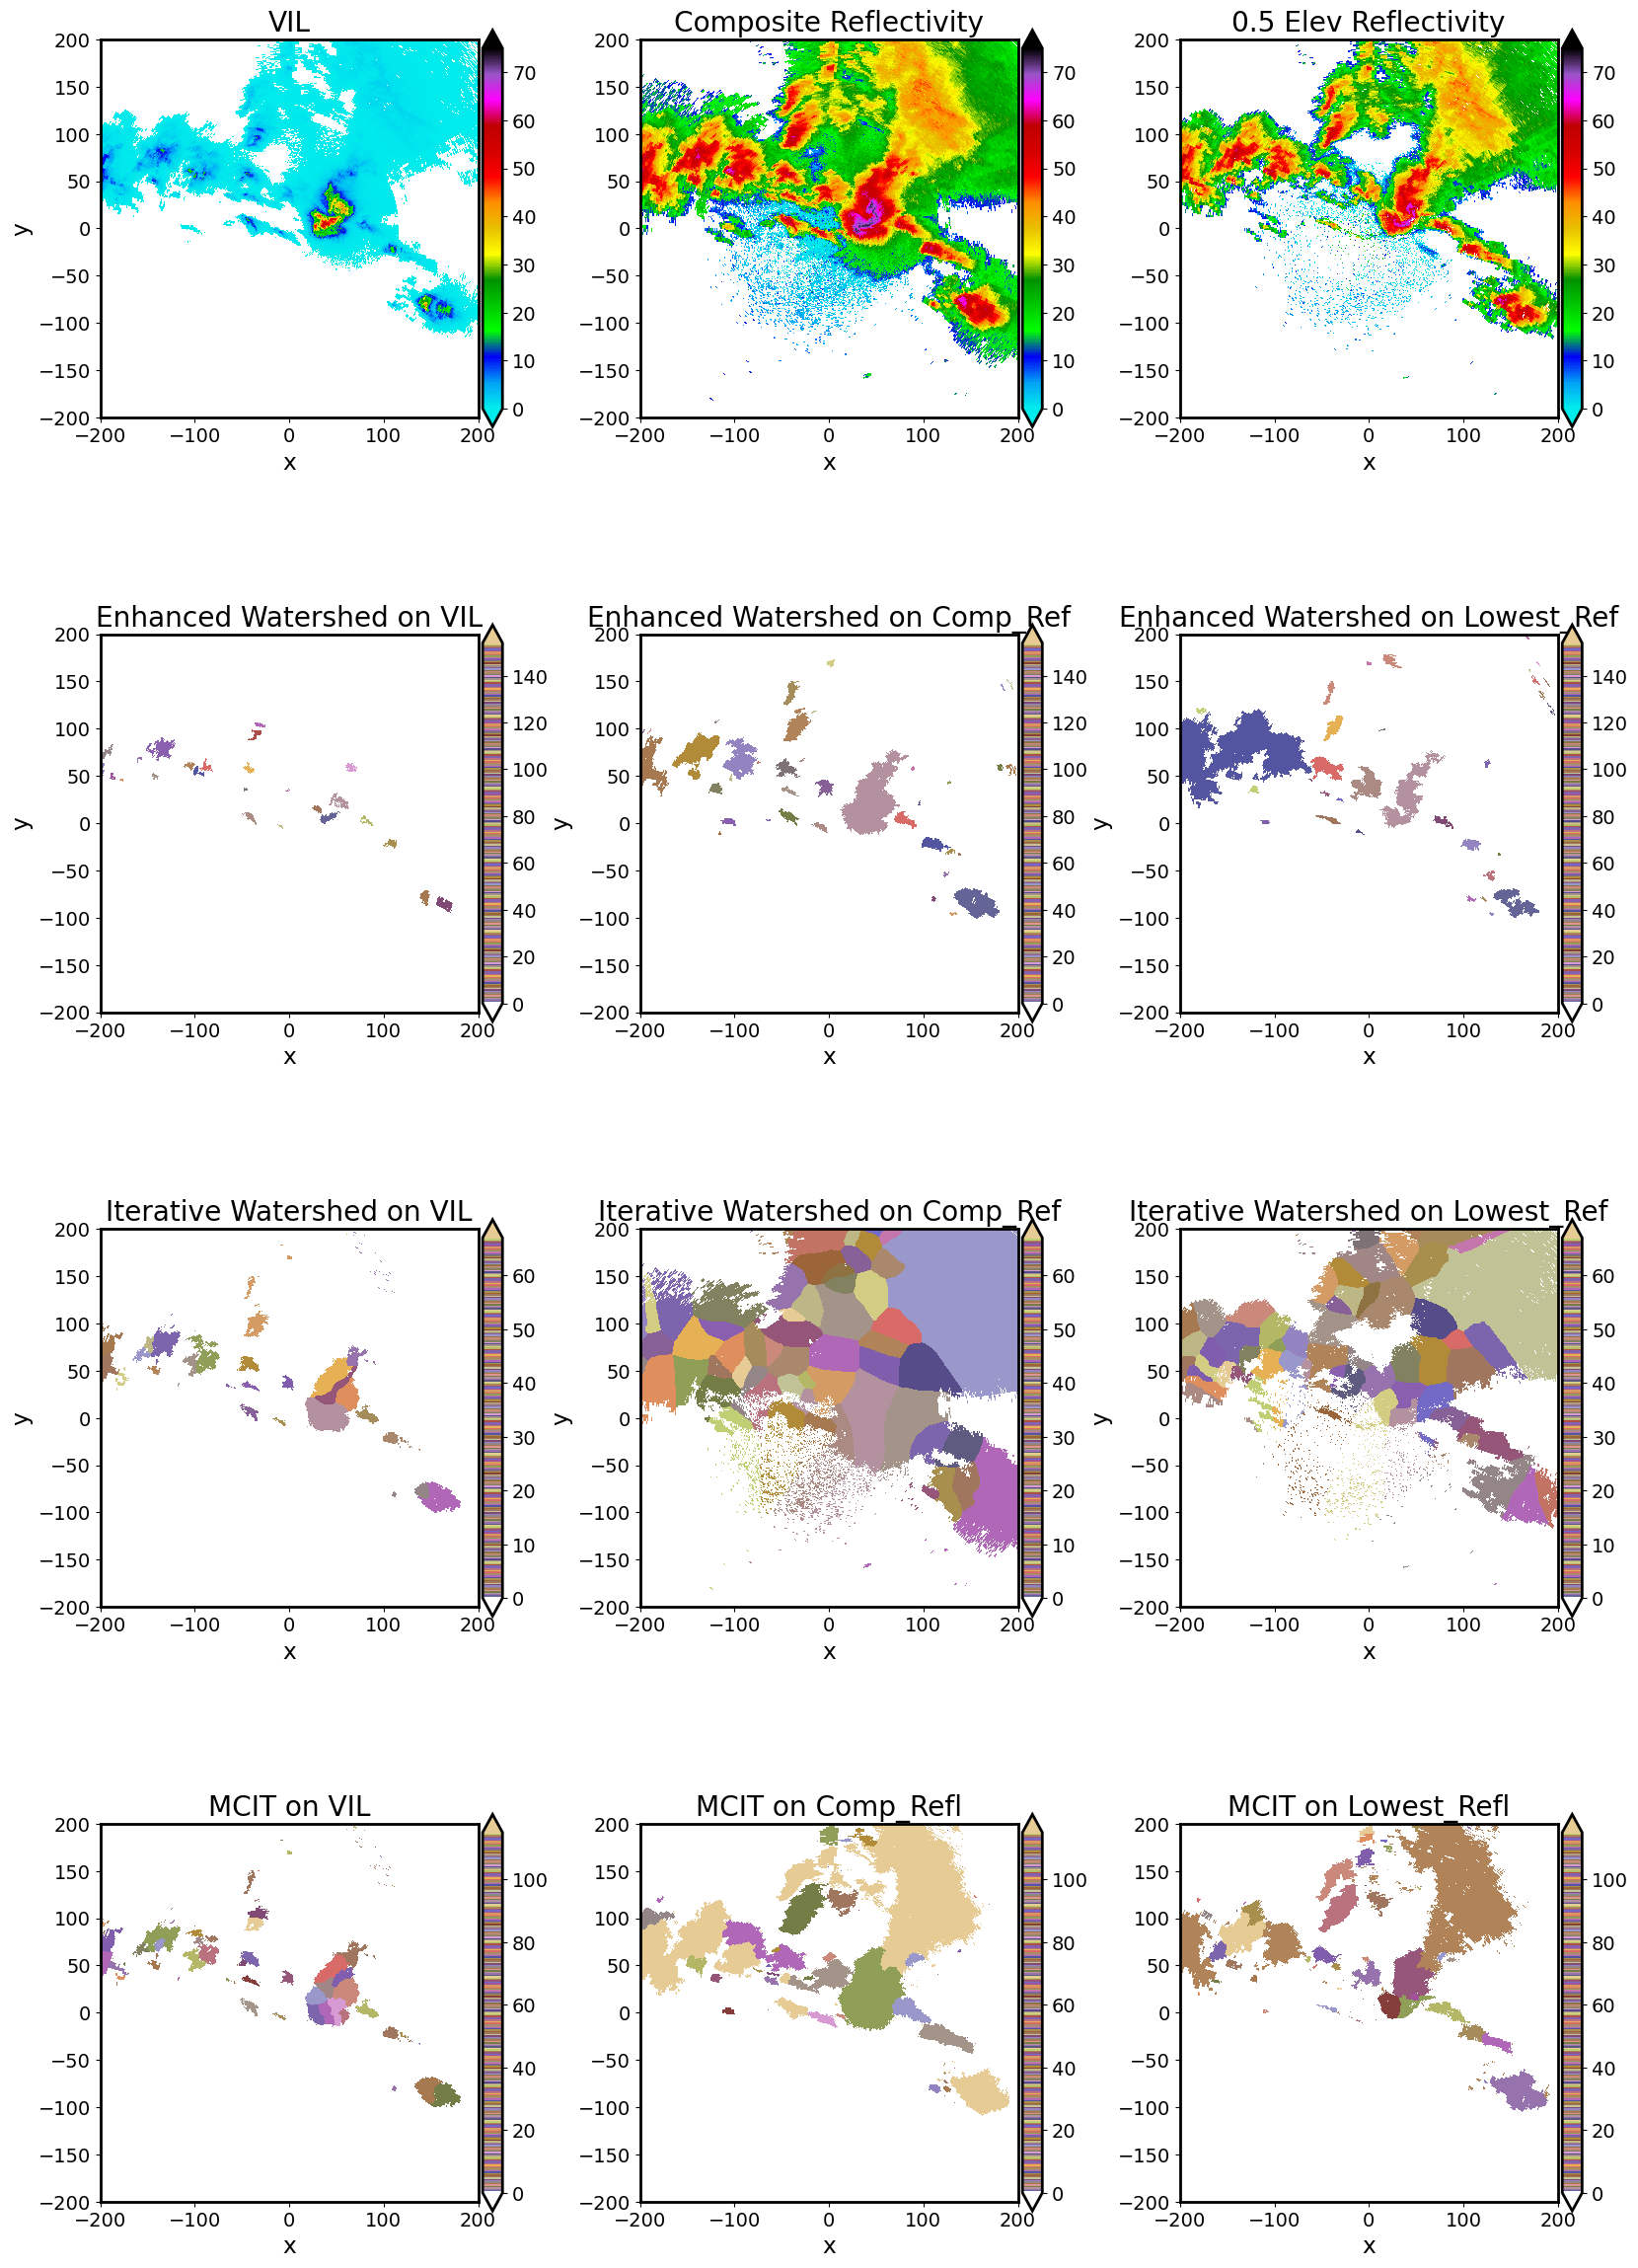

In [19]:
#make a big comparison plot
import matplotlib.pyplot as plt

plt.rcParams.update(plt.rcParamsDefault)

plt.rcParams.update(
        {'font.size': 14.0,
         'axes.titlesize': 'x-large',
         'axes.linewidth': 2.0,
         'axes.labelsize': 'large'}
    )

fig = plt.figure(figsize=(20, 30))
ax1 = fig.add_subplot(431)
ax1.set_aspect('equal')

ds_xy["VIL"].where(ds_xy["VIL"]>-10).plot(ax=ax1, x='x', y='y', vmin=0.0, vmax=75.0,
                        xlim=xlim, ylim=ylim, cmap='NWSRef',
                        add_colorbar=True,
                        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'',
                                     'shrink':0.8})

ax1.set_title("VIL")

ax2 = fig.add_subplot(432)
ax2.set_aspect('equal')


ds_xy["Comp_Ref"].where(ds_xy["Comp_Ref"]>-10).plot(ax=ax2, x='x', y='y', vmin=0.0, vmax=75.0,
                        xlim=xlim, ylim=ylim, cmap='NWSRef',
                        add_colorbar=True,
                        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'',
                                     'shrink':0.8})

ax2.set_title("Composite Reflectivity")
ax2.set_ylabel("")

ax3 = fig.add_subplot(433)
ax3.set_aspect('equal')



ds_xy["Lowest_Ref"].where(ds_xy["Lowest_Ref"]>-10).plot(ax=ax3, x='x', y='y', vmin=0.0, vmax=75.0,
                        xlim=xlim, ylim=ylim, cmap='NWSRef',
                        add_colorbar=True,
                        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'',
                                     'shrink':0.8})

ax3.set_title("0.5 Elev Reflectivity")
ax3.set_ylabel("")

ax4 = fig.add_subplot(434)
ax4.set_aspect('equal')

ds_xy["EW_vil_objects"].where(ds_xy["EW_vil_objects"]>-10).plot(ax=ax4, x='x', y='y', vmin=0.0, vmax=ds_xy["EW_lr_objects"].max(),
                        xlim=xlim, ylim=ylim, cmap=cmap,
                        add_colorbar=True,
                        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'',
                                     'shrink':0.8})

ax4.set_title("Enhanced Watershed on VIL")

ax5 = fig.add_subplot(435)
ax5.set_aspect('equal')

ds_xy["EW_cr_objects"].where(ds_xy["EW_cr_objects"]>-10).plot(ax=ax5, x='x', y='y', vmin=0.0, vmax=ds_xy["EW_lr_objects"].max(),
                        xlim=xlim, ylim=ylim, cmap=cmap,
                        add_colorbar=True,
                        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'',
                                     'shrink':0.8})

ax5.set_title("Enhanced Watershed on Comp_Ref")

ax6 = fig.add_subplot(436)
ax6.set_aspect('equal')

ds_xy["EW_lr_objects"].where(ds_xy["EW_lr_objects"]>-10).plot(ax=ax6, x='x', y='y', vmin=0.0, vmax=ds_xy["EW_lr_objects"].max(),
                        xlim=xlim, ylim=ylim, cmap=cmap,
                        add_colorbar=True,
                        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'',
                                     'shrink':0.8})

ax6.set_title("Enhanced Watershed on Lowest_Ref")


ax7 = fig.add_subplot(437)
ax7.set_aspect('equal')

ds_xy["IW_vil_objects"].where(ds_xy["IW_vil_objects"]>-10).plot(ax=ax7, x='x', y='y', vmin=0.0, vmax=ds_xy["IW_lr_objects"].max(),
                        xlim=xlim, ylim=ylim, cmap=cmap,
                        add_colorbar=True,
                        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'',
                                     'shrink':0.8})

ax7.set_title("Iterative Watershed on VIL")

ax8 = fig.add_subplot(438)
ax8.set_aspect('equal')

ds_xy["IW_cr_objects"].where(ds_xy["IW_cr_objects"]>-10).plot(ax=ax8, x='x', y='y', vmin=0.0, vmax=ds_xy["IW_lr_objects"].max(),
                        xlim=xlim, ylim=ylim, cmap=cmap,
                        add_colorbar=True,
                        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'',
                                     'shrink':0.8})

ax8.set_title("Iterative Watershed on Comp_Ref")

ax9 = fig.add_subplot(439)
ax9.set_aspect('equal')

ds_xy["IW_lr_objects"].where(ds_xy["IW_lr_objects"]>-10).plot(ax=ax9, x='x', y='y', vmin=0.0, vmax=ds_xy["IW_lr_objects"].max(),
                        xlim=xlim, ylim=ylim, cmap=cmap,
                        add_colorbar=True,
                        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'',
                                     'shrink':0.8})

ax9.set_title("Iterative Watershed on Lowest_Ref")

ax10 = fig.add_subplot(4,3,10)
ax10.set_aspect('equal')


ds_xy["MCIT_vil_objects"].where(ds_xy["MCIT_vil_objects"]>-10).plot(ax=ax10, x='x', y='y', vmin=0.0, vmax=ds_xy["MCIT_lr_objects"].max(),
                        xlim=xlim, ylim=ylim, cmap=cmap,
                        add_colorbar=True,
                        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'',
                                     'shrink':0.8})

ax10.set_title("MCIT on VIL")
ax10.set_ylabel("")

ax11 = fig.add_subplot(4,3,11)
ax11.set_aspect('equal')


ds_xy["MCIT_cr_objects"].where(ds_xy["MCIT_cr_objects"]>-10).plot(ax=ax11, x='x', y='y', vmin=0.0, vmax=ds_xy["MCIT_lr_objects"].max(),
                        xlim=xlim, ylim=ylim, cmap=cmap,
                        add_colorbar=True,
                        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'',
                                     'shrink':0.8})

ax11.set_title("MCIT on Comp_Refl")
ax11.set_ylabel("")

ax12 = fig.add_subplot(4,3,12)
ax12.set_aspect('equal')


ds_xy["MCIT_lr_objects"].where(ds_xy["MCIT_lr_objects"]>-10).plot(ax=ax12, x='x', y='y', vmin=0.0, vmax=ds_xy["MCIT_lr_objects"].max(),
                        xlim=xlim, ylim=ylim, cmap=cmap,
                        add_colorbar=True,
                        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'',
                                     'shrink':0.8})

ax12.set_title("MCIT on Lowest_Refl")
ax12.set_ylabel("")

plt.show()

